In [2]:
import numpy as np
import sympy as sp

%matplotlib nbagg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pyJHTDB
from pyJHTDB import libJHTDB
from pyJHTDB.dbinfo import interpolation_code
from pyJHTDB.dbinfo import isotropic1024coarse as info
import pickle

/Users/tdrivas/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [ ]:
nu = info['nu']
energy_diss = info['diss']
kolmogorov_time = (nu/energy_diss)**.5
kolmogorov_length = nu**(3/4.)*energy_diss**(-1/4.)

npoints = 2
nparticles = 10
nsteps = info['time'].shape[0] #total of 124

T = info['time'][-1];
subdivisions = 2
t = np.linspace(info['time'][-1], info['time'][0], num = subdivisions*nsteps + 1)
tau = t[0]-t
dt              = t[0] - t[1]
sqrtdt          = abs(dt)**.5

x0 = np.zeros(shape = (npoints, nparticles, 3), dtype = np.float32)
x0[..., 0] = info['lx']*np.random.random(size = (npoints,))[:, None]
x0[..., 1] = info['ynodes'][info['ynodes'].shape[0]//2]
x0[..., 2] = info['lz']*np.random.random(size = (npoints,))[:, None]

numcombs =  np.float(nparticles*(nparticles - 1)/2.)

In [ ]:
PrandtlNumbers = np.array([1e1, 1e0, 1e-1])
for m in range(PrandtlNumbers.shape[0]): 
    x    = x0.copy()
    r    = np.zeros(shape = (npoints, nparticles, nparticles),  dtype = np.float32)
    disp = np.zeros(shape = (subdivisions*nsteps + 1, npoints), dtype = np.float32)
    
    Prandtl = np.float(PrandtlNumbers[m])
    kappa = nu/Prandtl
    noiseamplitude  = (2*kappa)**.5
    
    lJHTDB = libJHTDB()
    lJHTDB.initialize()
    for tindex in range(subdivisions*nsteps):
        print('step {0} of {1} for Pr = {2}'.format(tindex, subdivisions*nsteps, Prandtl))
        u = lJHTDB.getData(
                    t[tindex],
                    x,
                    sinterp = interpolation_code['M2Q8'],
                    tinterp = interpolation_code['NoTInt'],
                    data_set = info['name'],
                    getFunction = 'getVelocity')
        dW = np.random.randn(*x.shape)*sqrtdt
        dX = -u*dt + noiseamplitude*dW
        x += dX
        for k in range(npoints):
            for i in range(nparticles):
                for j in range(nparticles):
                    if i<j:
                        r[k,i,j] =    np.sum(np.square(x[k, i, :] - x[k, j, :]))  
        disp[tindex + 1] = np.sum(np.sum(r, axis=2),axis=1)/float(numcombs)
    lJHTDB.finalize()

    ####### Dump Data #######
    suffix = 'Traj_{0}_Pr_{1}.p'.format(nparticles, Prandtl)
    pickle.dump(x,    open( "data_isotropic/x"    + suffix, "wb" ) )
    pickle.dump(t,    open( "data_isotropic/t"    + suffix, "wb" ) )
    pickle.dump(disp, open( "data_isotropic/disp" + suffix, "wb" ) )

step 0 of 2048 for Pr = 10.0
step 1 of 2048 for Pr = 10.0
step 2 of 2048 for Pr = 10.0
step 3 of 2048 for Pr = 10.0
step 4 of 2048 for Pr = 10.0
step 5 of 2048 for Pr = 10.0
step 6 of 2048 for Pr = 10.0
step 7 of 2048 for Pr = 10.0
step 8 of 2048 for Pr = 10.0
step 9 of 2048 for Pr = 10.0
step 10 of 2048 for Pr = 10.0
step 11 of 2048 for Pr = 10.0
step 12 of 2048 for Pr = 10.0
step 13 of 2048 for Pr = 10.0
step 14 of 2048 for Pr = 10.0
step 15 of 2048 for Pr = 10.0
step 16 of 2048 for Pr = 10.0
step 17 of 2048 for Pr = 10.0
step 18 of 2048 for Pr = 10.0
step 19 of 2048 for Pr = 10.0
step 20 of 2048 for Pr = 10.0

In [6]:
####### Load Data #######
nparticles = 10
Prandtl1 = PrandtlNumbers[0]
Prandtl2 = PrandtlNumbers[1]
Prandtl3 = PrandtlNumbers[2]
suffix1 = 'Traj_{0}_Pr_{1}.p'.format(nparticles, Prandtl1)
suffix2 = 'Traj_{0}_Pr_{1}.p'.format(nparticles, Prandtl2)
suffix3 = 'Traj_{0}_Pr_{1}.p'.format(nparticles, Prandtl3)

t     = pickle.load( open( "data_isotropic/t"       + suffix1, "rb" ) )
disp1 = pickle.load( open( "data_isotropic/disp"    + suffix1, "rb" ) )
disp2 = pickle.load( open( "data_isotropic/disp"    + suffix2, "rb" ) )
disp3 = pickle.load( open( "data_isotropic/disp"    + suffix3, "rb" ) )

In [7]:
print disp1
print disp2
print disp3

[[  0.00000000e+00   0.00000000e+00]
 [  4.82848086e+21   8.72586335e+23]
 [  4.82848086e+21   8.72586335e+23]
 ..., 
 [  4.82848086e+21   8.72586335e+23]
 [  4.82848086e+21   8.72586335e+23]
 [  4.82848086e+21   8.72586335e+23]]
[[  0.00000000e+00   0.00000000e+00]
 [  8.66340815e+23   2.06882342e+28]
 [  8.66340815e+23   2.06882342e+28]
 ..., 
 [  8.66340815e+23   2.06882342e+28]
 [  8.66340815e+23   2.06882342e+28]
 [  8.66340815e+23   2.06882342e+28]]
[[  0.00000000e+00   0.00000000e+00]
 [  4.82848086e+21   8.72586335e+23]
 [  4.82848086e+21   8.72586335e+23]
 ..., 
 [  4.82848086e+21   8.72586335e+23]
 [  4.82848086e+21   8.72586335e+23]
 [  4.82848086e+21   8.72586335e+23]]


/Users/tdrivas/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: overflow encountered in true_divide
/Users/tdrivas/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in true_divide
/Users/tdrivas/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: overflow encountered in true_divide


<IPython.core.display.Javascript object>


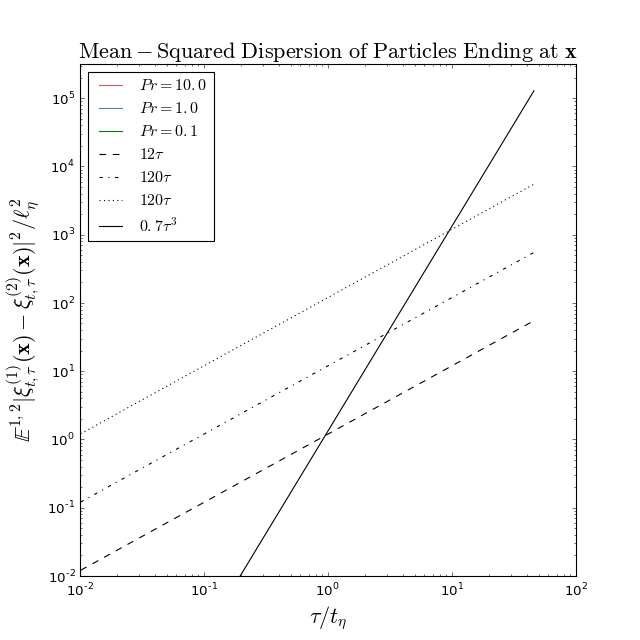

In [7]:
space_point_index = 1

Tau = tau/float(kolmogorov_time)
diffusion_dispersion1 = 12*Tau/Prandtl1
diffusion_dispersion2 = 12*Tau/Prandtl2
diffusion_dispersion3 = 12*Tau/Prandtl3
Richardson_dispersion = (4/3.)*Tau**3

disper1 = disp1[:,space_point_index]/float(kolmogorov_length**2)
disper2 = disp2[:,space_point_index]/float(kolmogorov_length**2)
disper3 = disp3[:,space_point_index]/float(kolmogorov_length**2)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(Tau, disper1, color = 'Indianred', label = '$Pr = {0}$'.format(Prandtl1))
ax.plot(Tau, disper2, color = 'Steelblue', label = '$Pr = {0}$'.format(Prandtl2))
ax.plot(Tau, disper3, color = 'green',     label = '$Pr = {0}$'.format(Prandtl3))
ax.plot(Tau, diffusion_dispersion1,   color = 'black', linestyle = 'dashed',  label = '$12 \\tau$')
ax.plot(Tau, diffusion_dispersion2,   color = 'black', linestyle = 'dashdot', label = '$120 \\tau$')
ax.plot(Tau, diffusion_dispersion3,   color = 'black', linestyle = 'dotted',  label = '$120 \\tau$')
ax.plot(Tau, Richardson_dispersion,   color = 'black', linestyle = 'solid',   label = '$0.7 \\tau^3$')
ax.set_ylim([10**(-2),10**(5.5)])
ax.set_title('$\\rm Mean-Squared\ Dispersion\ of\ Particles\ Ending\ at\ \\mathbf{x}$', fontsize=20)
ax.set_xlabel('$\\tau / t_\\eta$', fontsize=20)
ax.set_ylabel('$\mathbb{E}^{1,2} |{\\xi}^{(1)}_{t,\\tau}(\\mathbf{x})-{\\xi}^{(2)}_{t,\\tau}(\\mathbf{x})|^2 /\\ell_\\eta^2$', fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc ="best")

In [12]:
disper2

[0,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.9272533e+36,
 -1.927253